### Visualizes samples from Panoptic Narrative Grounding benchmark on MSCOCO

In [1]:
%load_ext autoreload
%autoreload 2

In [73]:
import os
from os.path import join, isdir, exists

from PIL import Image
from skimage import io
import numpy as np


In [5]:
os.chdir("../")

In [35]:
from clip_grounding.utils.paths import REPO_PATH, DATASET_ROOTS
from clip_grounding.utils.io import load_json
from clip_grounding.utils.visualize import show_single_image, set_latex_fonts

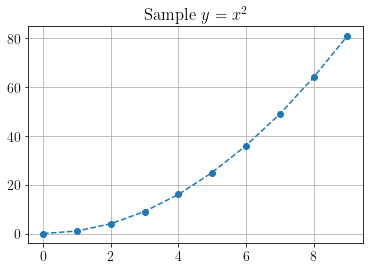

In [36]:
set_latex_fonts(show_sample=True)

In [10]:
REPO_PATH

'/Users/piyush/projects/CLIP-grounding'

In [11]:
PNG_ROOT = DATASET_ROOTS["PNG"]

In [12]:
PNG_ROOT

'/Users/piyush/projects/CLIP-grounding/data/panoptic_narrative_grounding'

In [14]:
assert isdir(PNG_ROOT)

In [16]:
!ls $PNG_ROOT/

__MACOSX    annotations images


### Load annotations for `val` set

In [17]:
phase = "val2017"

In [22]:
png_annotations_path = join(PNG_ROOT, "annotations", f"png_coco_{phase}.json")
png_annotations = load_json(png_annotations_path)

In [60]:
png_processed_annotations_path = join(PNG_ROOT, "annotations", f"png_coco_{phase}_dataloader.json")
png_processed_annotations = load_json(png_processed_annotations_path)

In [63]:
png_annotations[0]

{'image_id': '322944',
 'annotator_id': 38,
 'caption': 'A woman is holding teddy bear toy in her arms and she has some wounds on her face.',
 'segments': [{'utterance': 'a',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'woman',
   'segment_ids': ['4673118'],
   'plural': False,
   'noun': True},
  {'utterance': 'is holding',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'teddy bear toy',
   'segment_ids': ['6381410'],
   'plural': False,
   'noun': True},
  {'utterance': 'in her', 'segment_ids': [], 'plural': False, 'noun': False},
  {'utterance': 'arms', 'segment_ids': [], 'plural': True, 'noun': True},
  {'utterance': 'and she has some',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'wounds', 'segment_ids': [], 'plural': True, 'noun': True},
  {'utterance': 'on her', 'segment_ids': [], 'plural': False, 'noun': False},
  {'utterance': 'face',
   'segment_ids': ['4673118'],
   'plural': False

In [52]:
panoptic_path = join(PNG_ROOT, "annotations", f"panoptic_{phase}.json")
panoptic = load_json(panoptic_path)
images = panoptic["images"]
images = {i["id"]: i for i in images}
panoptic_anns = panoptic["annotations"]
panoptic_anns = {int(a["image_id"]): a for a in panoptic_anns}

In [53]:
len(panoptic_anns)

5000

In [55]:
panoptic_anns.keys()

dict_keys([139, 285, 632, 724, 776, 785, 802, 872, 885, 1000, 1268, 1296, 1353, 1425, 1490, 1503, 1532, 1584, 1675, 1761, 1818, 1993, 2006, 2149, 2153, 2157, 2261, 2299, 2431, 2473, 2532, 2587, 2592, 2685, 2923, 3156, 3255, 3501, 3553, 3661, 3845, 3934, 4134, 4395, 4495, 4765, 4795, 5001, 5037, 5060, 5193, 5477, 5503, 5529, 5586, 5600, 5992, 6012, 6040, 6213, 6460, 6471, 6614, 6723, 6763, 6771, 6818, 6894, 6954, 7088, 7108, 7278, 7281, 7386, 7511, 7574, 7784, 7795, 7816, 7818, 7888, 7977, 7991, 8021, 8211, 8277, 8532, 8629, 8690, 8762, 8844, 8899, 9378, 9400, 9448, 9483, 9590, 9769, 9772, 9891, 9914, 10092, 10363, 10583, 10707, 10764, 10977, 10995, 11051, 11122, 11149, 11197, 11511, 11615, 11699, 11760, 11813, 12062, 12120, 12280, 12576, 12639, 12667, 12670, 12748, 13004, 13177, 13201, 13291, 13348, 13546, 13597, 13659, 13729, 13774, 13923, 14007, 14038, 14226, 14380, 14439, 14473, 14831, 14888, 15079, 15254, 15272, 15278, 15335, 15338, 15440, 15497, 15517, 15597, 15660, 15746, 15751, 

In [56]:
panoptic_anns[int(image_id)]

{'segments_info': [{'id': 4673118,
   'category_id': 1,
   'iscrowd': 0,
   'bbox': [33, 4, 379, 625],
   'area': 116444},
  {'id': 6381410,
   'category_id': 88,
   'iscrowd': 0,
   'bbox': [16, 210, 398, 414],
   'area': 63021},
  {'id': 2500134,
   'category_id': 199,
   'iscrowd': 0,
   'bbox': [0, 0, 457, 640],
   'area': 107065}],
 'file_name': '000000322944.png',
 'image_id': 322944}

In [45]:
len(seg_annotations)

5

In [46]:
seg_annotations.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [77]:
len(seg_annotations["categories"])

133

In [82]:
categories = {x["id"]: x["name"] for x in seg_annotations["categories"]}

In [47]:
seg_annotations["images"][0]

{'license': 4,
 'file_name': '000000397133.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 17:02:52',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'id': 397133}

In [49]:
seg_annotations["info"]

{'description': 'COCO 2018 Panoptic Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2018,
 'contributor': 'https://arxiv.org/abs/1801.00868',
 'date_created': '2018-06-01 00:00:00.0'}

In [23]:
len(png_annotations)

8573

In [89]:
image_id

'322944'

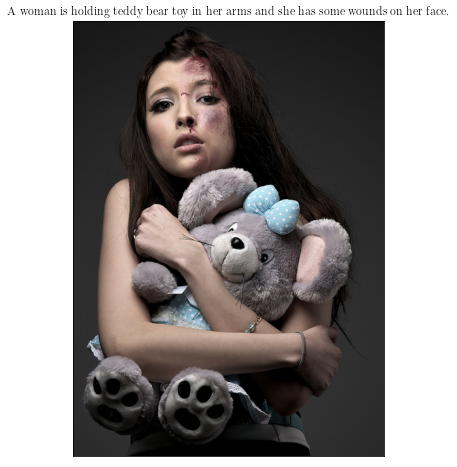

Categories present:  ['kite', 'microwave', 'bridge']
Categories present:  ['person', 'bicycle']


In [99]:
idx = 0

item = png_annotations[idx]

image_id = item["image_id"]
image_path = join(PNG_ROOT, "images", phase, f"{image_id.zfill(12)}.jpg")
assert exists(image_path)

image = Image.open(image_path)
caption = item["caption"]
show_single_image(image, title=caption, titlesize=12)

segment_idx = 3
segment = item["segments"][segment_idx]

# get panoptic annotations for this image
panoptic_ann = panoptic_anns[int(image_id)]

panoptic_segm = io.imread(join(PNG_ROOT, "annotations/panoptic_segmentation", phase, f"{image_id.zfill(12)}.png".format()))
categories_present = np.unique(panoptic_segm)
print("Categories present: ", [categories[c] for c in categories_present if c in categories])

panoptic_pred = io.imread(join(PNG_ROOT, "features", phase, "panoptic_seg_predictions", f"{image_id.zfill(12)}.png"))[:, :, 0]
categories_present = np.unique(panoptic_pred)
print("Categories present: ", [categories[c] for c in categories_present if c in categories])

In [93]:
np.unique(panoptic_pred)

array([0, 1, 2], dtype=uint8)

In [97]:
panoptic_pred.shape

(640, 457)

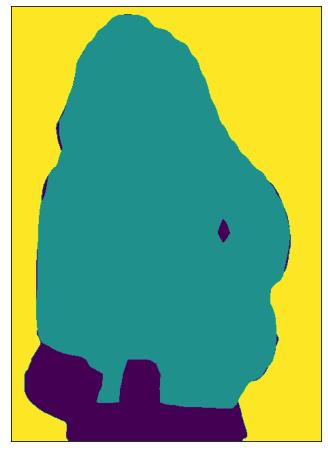

In [98]:
show_single_image(panoptic_pred)

In [58]:
panoptic_ann

{'segments_info': [{'id': 4673118,
   'category_id': 1,
   'iscrowd': 0,
   'bbox': [33, 4, 379, 625],
   'area': 116444},
  {'id': 6381410,
   'category_id': 88,
   'iscrowd': 0,
   'bbox': [16, 210, 398, 414],
   'area': 63021},
  {'id': 2500134,
   'category_id': 199,
   'iscrowd': 0,
   'bbox': [0, 0, 457, 640],
   'area': 107065}],
 'file_name': '000000322944.png',
 'image_id': 322944}

In [43]:
segment

{'utterance': 'teddy bear toy',
 'segment_ids': ['6381410'],
 'plural': False,
 'noun': True}

In [25]:
png_annotations[0]

{'image_id': '322944',
 'annotator_id': 38,
 'caption': 'A woman is holding teddy bear toy in her arms and she has some wounds on her face.',
 'segments': [{'utterance': 'a',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'woman',
   'segment_ids': ['4673118'],
   'plural': False,
   'noun': True},
  {'utterance': 'is holding',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'teddy bear toy',
   'segment_ids': ['6381410'],
   'plural': False,
   'noun': True},
  {'utterance': 'in her', 'segment_ids': [], 'plural': False, 'noun': False},
  {'utterance': 'arms', 'segment_ids': [], 'plural': True, 'noun': True},
  {'utterance': 'and she has some',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'wounds', 'segment_ids': [], 'plural': True, 'noun': True},
  {'utterance': 'on her', 'segment_ids': [], 'plural': False, 'noun': False},
  {'utterance': 'face',
   'segment_ids': ['4673118'],
   'plural': False

[{'utterance': 'a', 'segment_ids': [], 'plural': False, 'noun': False},
 {'utterance': 'woman',
  'segment_ids': ['4673118'],
  'plural': False,
  'noun': True},
 {'utterance': 'is holding',
  'segment_ids': [],
  'plural': False,
  'noun': False},
 {'utterance': 'teddy bear toy',
  'segment_ids': ['6381410'],
  'plural': False,
  'noun': True},
 {'utterance': 'in her', 'segment_ids': [], 'plural': False, 'noun': False},
 {'utterance': 'arms', 'segment_ids': [], 'plural': True, 'noun': True},
 {'utterance': 'and she has some',
  'segment_ids': [],
  'plural': False,
  'noun': False},
 {'utterance': 'wounds', 'segment_ids': [], 'plural': True, 'noun': True},
 {'utterance': 'on her', 'segment_ids': [], 'plural': False, 'noun': False},
 {'utterance': 'face',
  'segment_ids': ['4673118'],
  'plural': False,
  'noun': True},
 {'utterance': '.', 'segment_ids': [], 'plural': False, 'noun': False}]

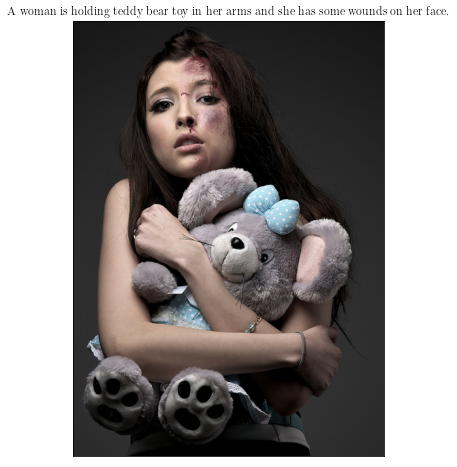